In [6]:
# ==============================================
# 1. Montar o Google Drive
# ==============================================
from google.colab import drive
drive.mount('/content/drive')

# ==============================================
# 2. Importações
# ==============================================
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             f1_score, matthews_corrcoef, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import warnings
warnings.filterwarnings('ignore')

# ==============================================
# 3. Leitura do dataset
# ==============================================
OutPath = "/content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/"
data = pd.read_csv(os.path.join(OutPath, "Sinantb_desfechos5anosEspecialistasELiteraturaDias_05-10-2025_16-17-15.csv"))

colunas_remover = ['BENEF_GOV', 'POP_IMIG', 'POP_SAUDE', 'AGRAVOUTRA', 'AGRAVDOENC', 'POP_LIBER',
                   'AGRAVALCOO', 'AGRAVDROGA', 'AGRAVTABAC', 'DT_DIAG', 'DT_INIC_TR', 'year', 'NU_COMU_EX', 'NU_CONTATO']
data.drop(columns=colunas_remover, inplace=True)
X = data.drop("DESFECHO", axis=1)
y = data["DESFECHO"]
print(data.columns)

# ==============================================
# 4. Criação única do conjunto de teste balanceado
# ==============================================
np.random.seed(42)
minority_class = y.value_counts().idxmin()
majority_class = y.value_counts().idxmax()
test_size = int(y.value_counts()[minority_class] * 0.2)

minority_indices = np.random.choice(y[y == minority_class].index, test_size, replace=False)
majority_indices = np.random.choice(y[y == majority_class].index, test_size, replace=False)
test_indices = np.concatenate([minority_indices, majority_indices])

X_test_bal = X.loc[test_indices]
y_test_bal = y.loc[test_indices]

X_train_raw = X.drop(test_indices)
y_train_raw = y.drop(test_indices)

# ==============================================
# 5. Modelos e Parâmetros
# ==============================================
modelos = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

param_grids = {
    "DecisionTree": {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "RandomForest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "GradientBoosting": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7]
    }
}

balanceamentos = {
    "Undersampling": RandomUnderSampler(random_state=42),
    "Oversampling": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42)
}

# ==============================================
# 6. Experimentos
# ==============================================
results_train = []
results_test = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for bal_name, balancer in balanceamentos.items():
    X_train_bal, y_train_bal = balancer.fit_resample(X_train_raw, y_train_raw)

    for mod_name, model in modelos.items():
        grid_search = GridSearchCV(model, param_grids[mod_name], cv=cv, scoring='f1_macro', n_jobs=-1)
        grid_search.fit(X_train_bal, y_train_bal)

        print(f"\nMelhores parâmetros para {mod_name} com {bal_name}:")
        print(grid_search.best_params_)
        print(f"Melhor F1-Macro (treino - CV): {grid_search.best_score_:.4f}")

        # Salvar o modelo otimizado após treinamento com GridSearch
        model_path = os.path.join(OutPath, f"{mod_name}_{bal_name}_otimizado.pkl")
        joblib.dump(grid_search.best_estimator_, model_path)
        print(f"Modelo salvo em: {model_path}")

        # Métricas Treino (cross-validation)
        y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train_bal, y_train_bal, cv=cv, method='predict')
        y_train_proba = cross_val_predict(grid_search.best_estimator_, X_train_bal, y_train_bal, cv=cv, method='predict_proba')[:,1]

        cm_train = confusion_matrix(y_train_bal, y_train_pred)
        tn, fp, fn, tp = cm_train.ravel()

        results_train.append({
            'Balanceamento': bal_name,
            'Modelo': mod_name,
            'Accuracy': accuracy_score(y_train_bal, y_train_pred),
            'F1-Score': f1_score(y_train_bal, y_train_pred),
            'F1-Macro': f1_score(y_train_bal, y_train_pred, average='macro'),
            'MCC': matthews_corrcoef(y_train_bal, y_train_pred),
            'Specificity': tn / (tn + fp),
            'Sensitivity': tp / (tp + fn),
            'AUC-ROC': roc_auc_score(y_train_bal, y_train_proba)
        })

        # Métricas Teste
        y_test_pred = grid_search.predict(X_test_bal)
        y_test_proba = grid_search.predict_proba(X_test_bal)[:,1]
        cm_test = confusion_matrix(y_test_bal, y_test_pred)
        tn, fp, fn, tp = cm_test.ravel()

        results_test.append({
            'Balanceamento': bal_name,
            'Modelo': mod_name,
            'Accuracy': accuracy_score(y_test_bal, y_test_pred),
            'F1-Score': f1_score(y_test_bal, y_test_pred),
            'F1-Macro': f1_score(y_test_bal, y_test_pred, average='macro'),
            'MCC': matthews_corrcoef(y_test_bal, y_test_pred),
            'Specificity': tn / (tn + fp),
            'Sensitivity': tp / (tp + fn),
            'AUC-ROC': roc_auc_score(y_test_bal, y_test_proba)
        })

# ==============================================
# 7. Tabelas consolidadas
# ==============================================
def highlight_max(s):
    return ['font-weight: bold' if v == s.max() else '' for v in s]

df_results_train = pd.DataFrame(results_train)
df_results_test = pd.DataFrame(results_test)

print("\nTabela de Resultados - Treino:")
display(df_results_train.style.apply(highlight_max, subset=df_results_train.columns[2:]))

print("\nTabela de Resultados - Teste:")
display(df_results_test.style.apply(highlight_max, subset=df_results_test.columns[2:]))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['ID_MUNICIP', 'CS_SEXO', 'CS_RACA', 'CS_ESCOL_N', 'TRATAMENTO',
       'AGRAVDIABE', 'HIV', 'POP_RUA', 'REGIAO', 'IDADE',
       'PROP_CONTATOS_EXAMINADOS', 'DIAS_ATE_INICIO_TRATAMENTO', 'DESFECHO'],
      dtype='object')

Melhores parâmetros para DecisionTree com Undersampling:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Melhor F1-Macro (treino - CV): 0.6330
Modelo salvo em: /content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/DecisionTree_Undersampling_otimizado.pkl

Melhores parâmetros para RandomForest com Undersampling:
{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
Melhor F1-Macro (treino - CV): 0.6442
Modelo salvo em: /content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/RandomForest_Undersampling_otimiza

,Balanceamento,Modelo,Accuracy,F1-Score,F1-Macro,MCC,Specificity,Sensitivity,AUC-ROC
0,Undersampling,DecisionTree,0.637045,0.671630,0.632973,0.280381,0.531719,0.742370,0.675390
1,Undersampling,RandomForest,0.646114,0.669994,0.644251,0.295336,0.573751,0.718476,0.695958
2,Undersampling,GradientBoosting,0.653302,0.675177,0.651723,0.309424,0.585959,0.720646,0.707492
3,Undersampling,XGBoost,0.651407,0.673742,0.649766,0.305693,0.582950,0.719865,0.707205
4,Oversampling,DecisionTree,0.847386,0.830190,0.845805,0.709476,0.948653,0.746119,0.856930
5,Oversampling,RandomForest,0.882867,0.875409,0.882446,0.771283,0.942731,0.823004,0.955006
6,Oversampling,GradientBoosting,0.707170,0.716456,0.706856,0.415232,0.674423,0.739917,0.779843
7,Oversampling,XGBoost,0.682513,0.698163,0.681657,0.367005,0.630665,0.734361,0.748538
8,SMOTE,DecisionTree,0.747902,0.743122,0.747815,0.496148,0.766511,0.729294,0.753459
9,SMOTE,RandomForest,0.786951,0.790673,0.786884,0.574265,0.769171,0.804731,0.863321



Tabela de Resultados - Teste:


,Balanceamento,Modelo,Accuracy,F1-Score,F1-Macro,MCC,Specificity,Sensitivity,AUC-ROC
0,Undersampling,DecisionTree,0.633592,0.665293,0.630275,0.272110,0.538880,0.728304,0.671710
1,Undersampling,RandomForest,0.643138,0.666667,0.641351,0.289172,0.572553,0.713724,0.695843
2,Undersampling,GradientBoosting,0.653900,0.675456,0.652366,0.310551,0.587480,0.720319,0.710138
3,Undersampling,XGBoost,0.652800,0.674266,0.651286,0.308290,0.586901,0.718699,0.707410
4,Oversampling,DecisionTree,0.559535,0.635550,0.539502,0.131013,0.350960,0.768109,0.559704
5,Oversampling,RandomForest,0.591993,0.673277,0.565073,0.212105,0.343208,0.840778,0.648188
6,Oversampling,GradientBoosting,0.646378,0.675997,0.643398,0.297775,0.554964,0.737792,0.698850
7,Oversampling,XGBoost,0.649734,0.675736,0.647467,0.303395,0.569544,0.729924,0.705241
8,SMOTE,DecisionTree,0.556411,0.622148,0.542565,0.120341,0.382435,0.730386,0.557068
9,SMOTE,RandomForest,0.582562,0.658946,0.560517,0.184688,0.358598,0.806526,0.634064


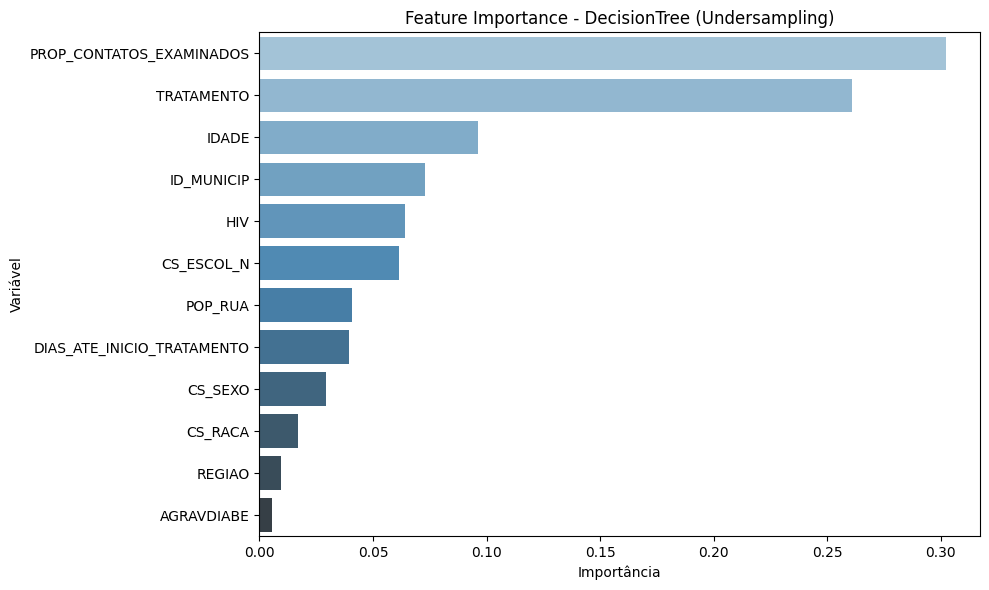

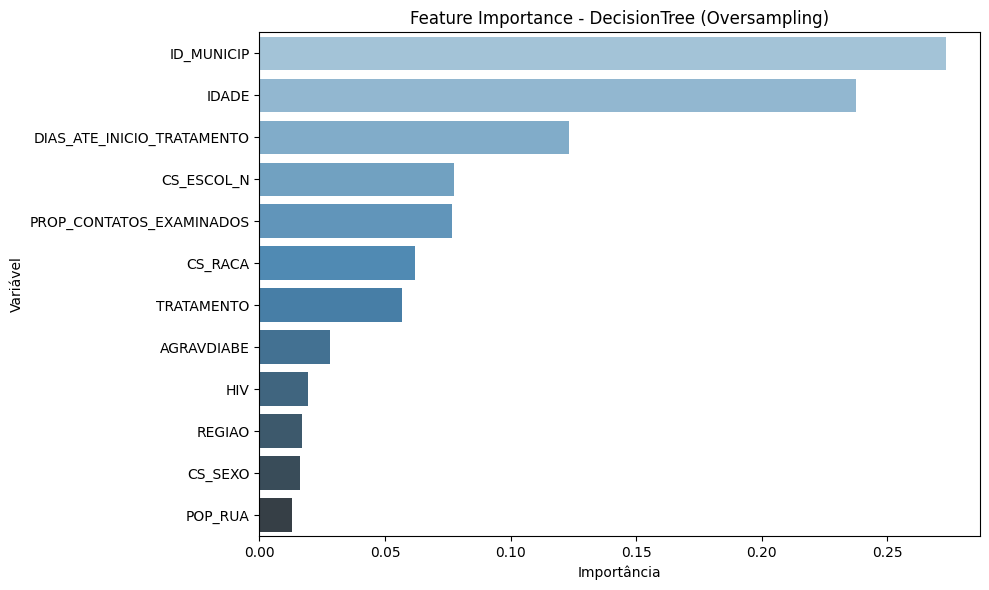

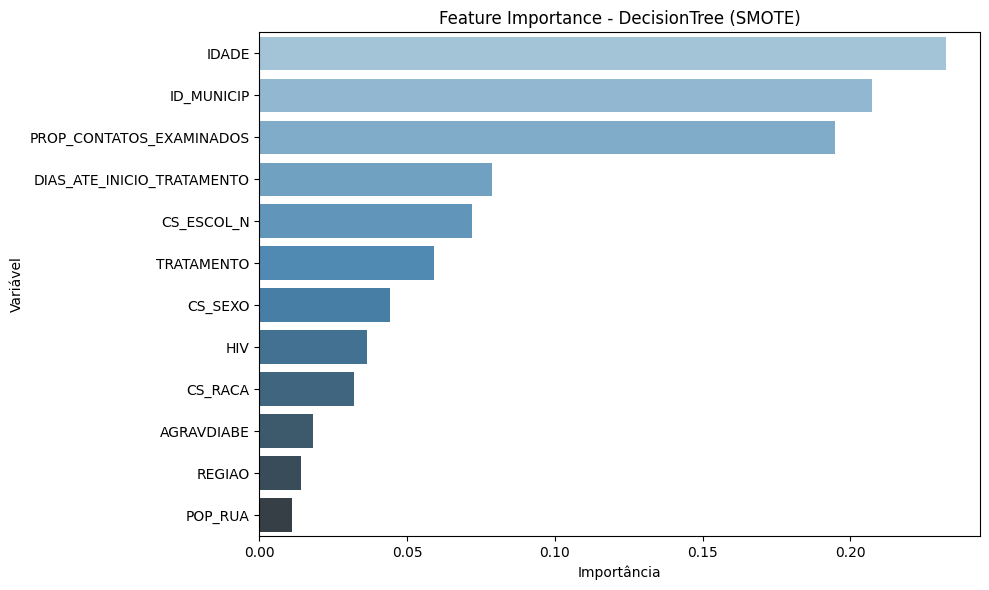

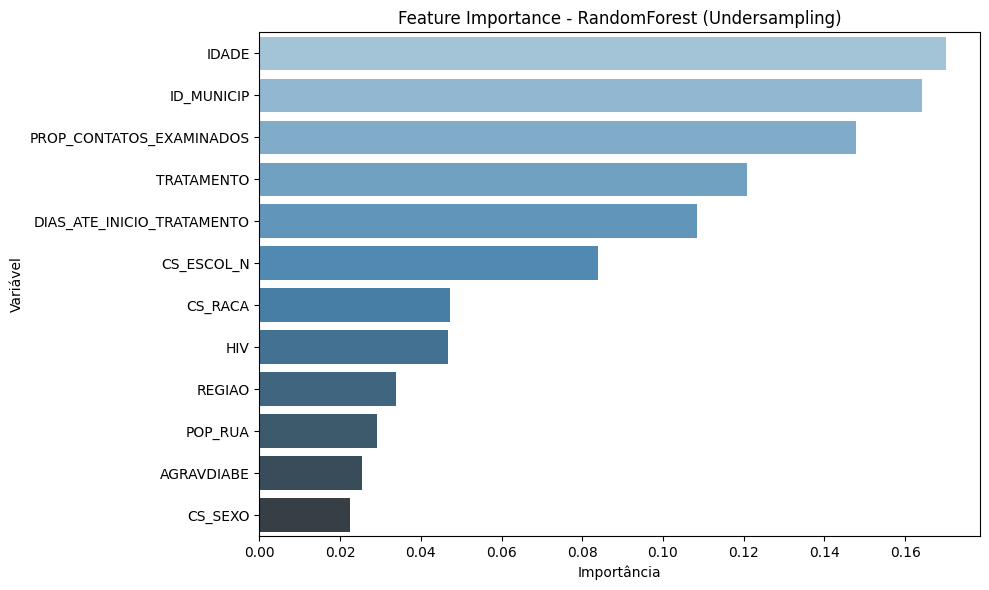

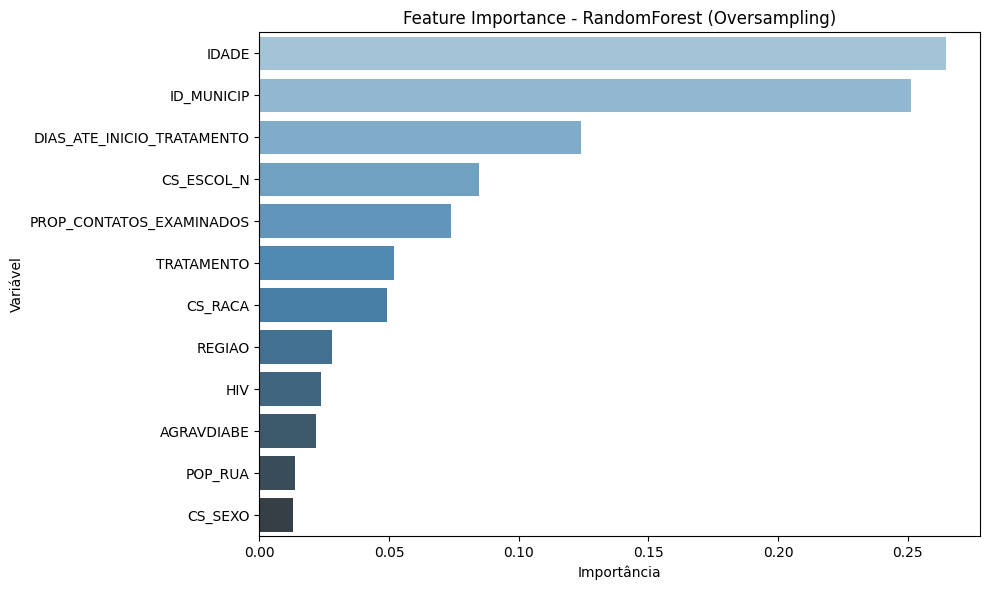

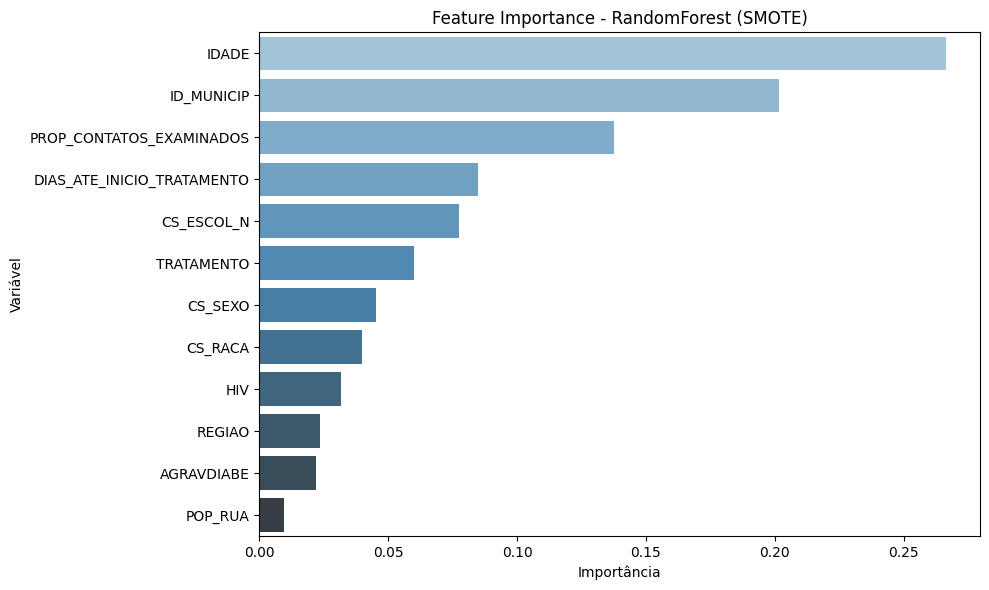

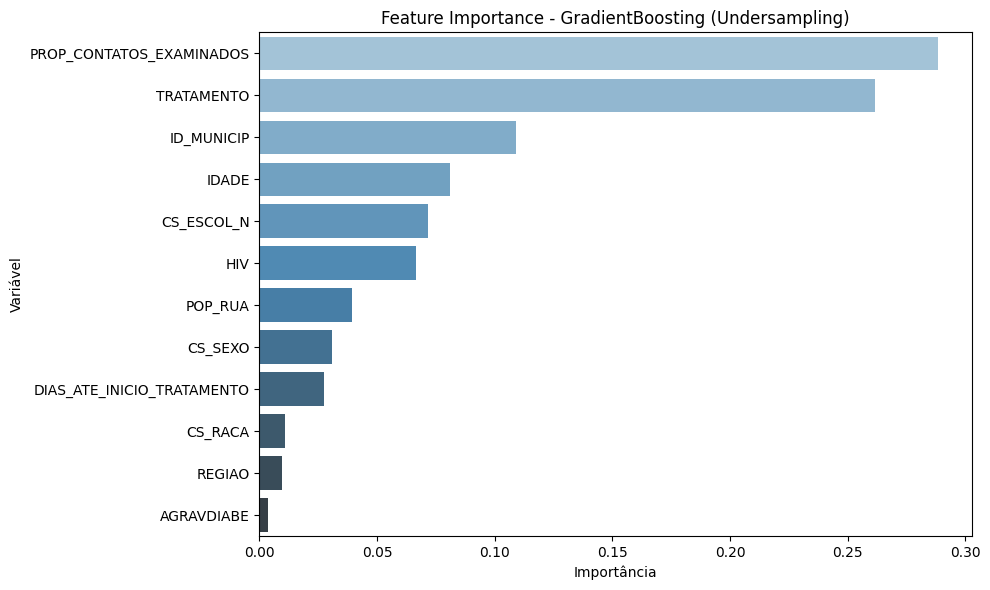

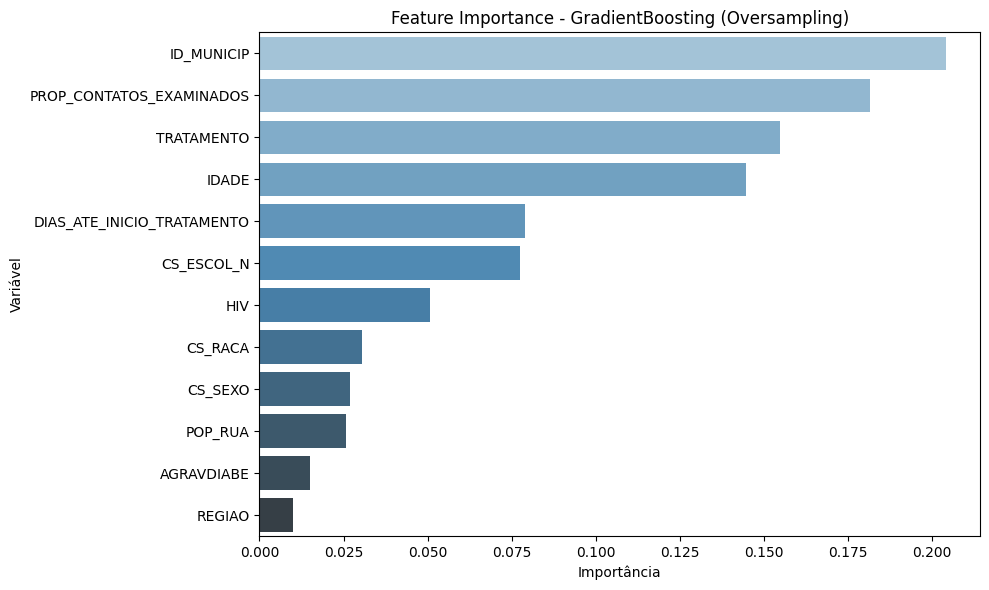

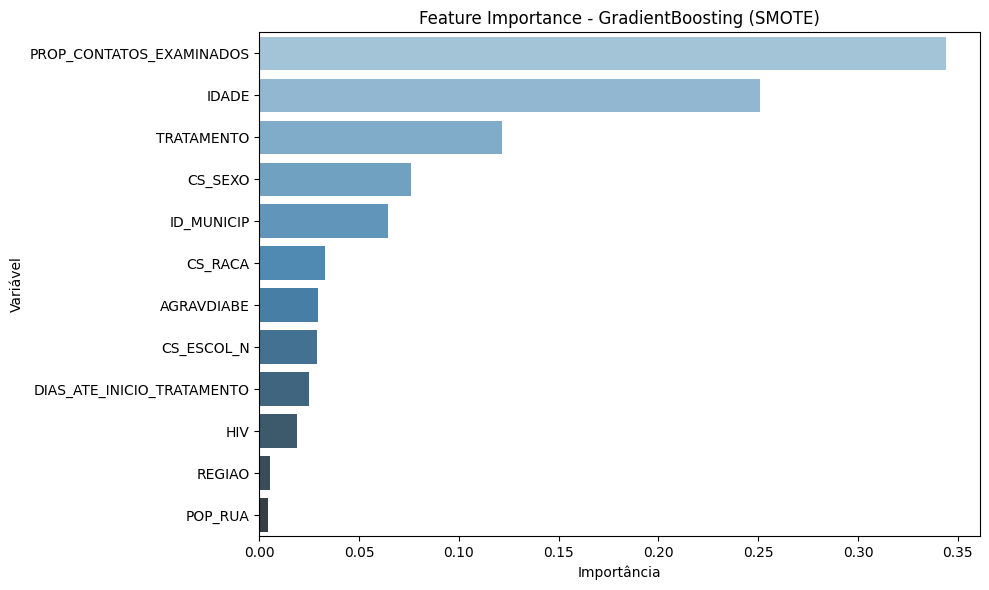

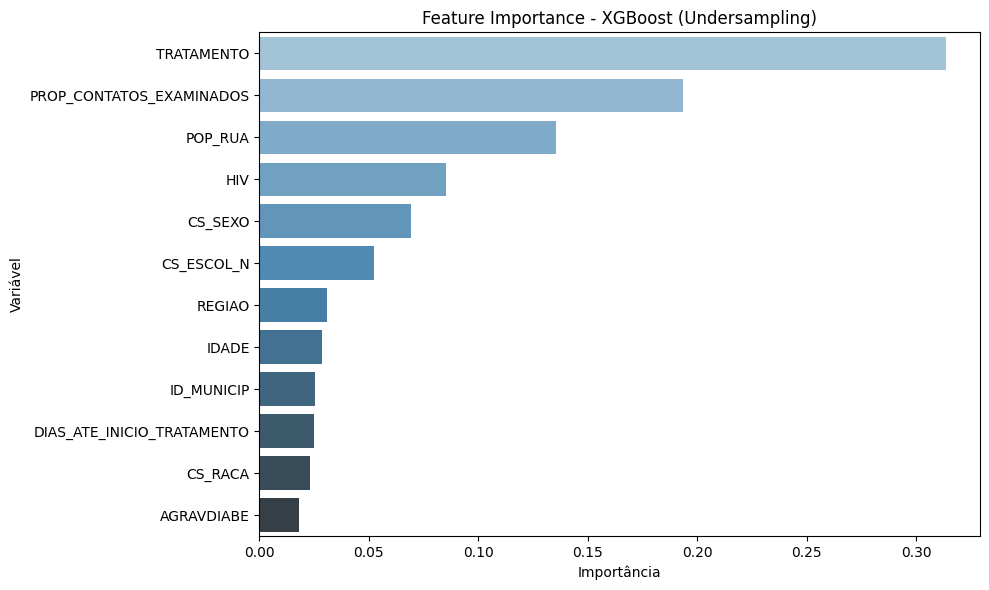

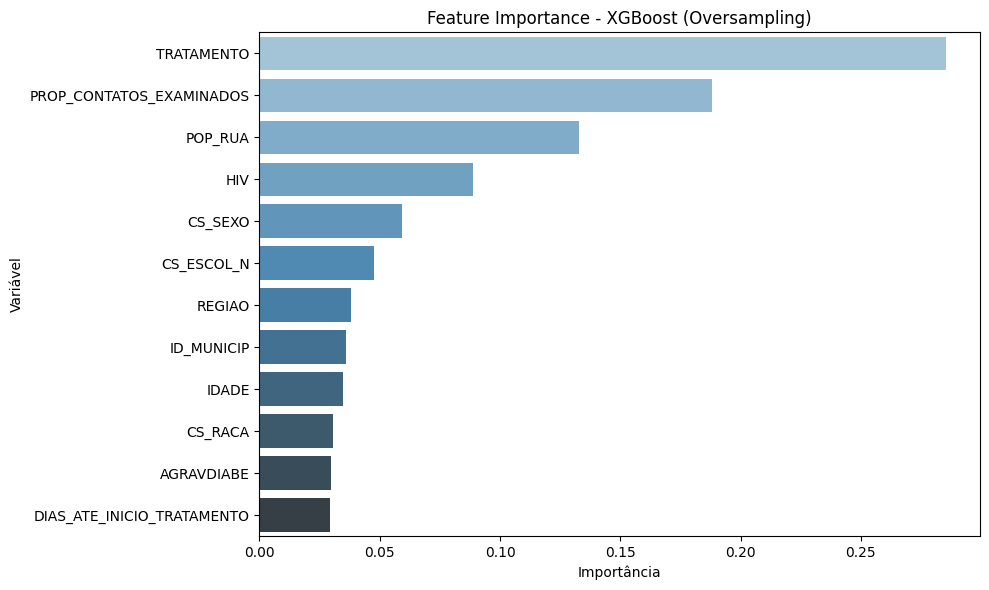

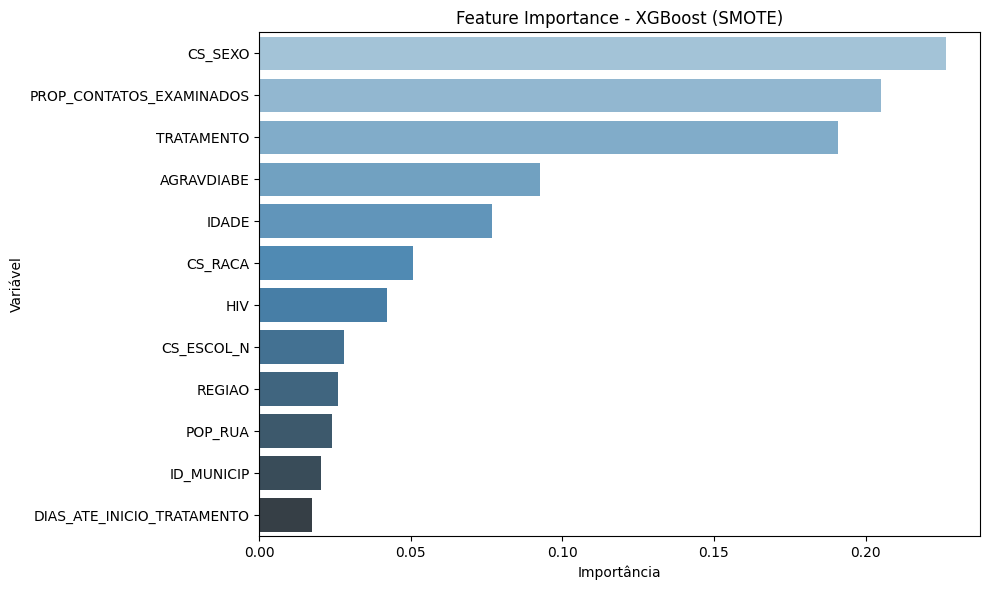

In [7]:
# =============================
# Importações necessárias
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# =============================
# Caminho onde os modelos estão salvos
# =============================
OutPath = "/content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/"

# Lista dos modelos e balanceamentos
modelos = ["DecisionTree", "RandomForest", "GradientBoosting", "XGBoost"]
balanceamentos = ["Undersampling", "Oversampling", "SMOTE"]

# =============================
# Carregamento e Feature Importance
# =============================
for modelo in modelos:
    for bal in balanceamentos:
        nome_modelo = f"{modelo}_{bal}_otimizado.pkl"
        caminho_modelo = os.path.join(OutPath, nome_modelo)

        if os.path.exists(caminho_modelo):
            clf = joblib.load(caminho_modelo)

            # Obter as importâncias das features
            if hasattr(clf, 'feature_importances_'):
                importancias = clf.feature_importances_
                indices = np.argsort(importancias)[::-1]

                # Nomes das features
                features = X.columns

                # Plotar gráfico
                plt.figure(figsize=(10, 6))
                sns.barplot(x=importancias[indices], y=features[indices], palette="Blues_d")
                plt.title(f"Feature Importance - {modelo} ({bal})")
                plt.xlabel('Importância')
                plt.ylabel('Variável')
                plt.tight_layout()
                plt.show()

            else:
                print(f"O modelo {modelo} ({bal}) não tem feature_importances_.")
        else:
            print(f"Modelo não encontrado: {caminho_modelo}")
